## Digital-analog variational quantum eigensolver(DAVQE)


In [3]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_nature
!pip install qutip
!pip install pyscf

     |████████████████████████████████| 2.0 MB 4.7 MB/s eta 0:00:01


     |████████████████████████████████| 23.6 MB 4.3 MB/s eta 0:00:01


In [29]:
from DA_VQE import *

This notebook implements a Digital-Analog variational quantum eigensolver (DA-VQE) to find the ground state energy of the hydrogen, LiH, and BeH2 molecules. In conventional VQE, entanglement of qubits is performed by the digital control gates such as CX gates.

DA-VQE, on the other hand, employs a time-evolution operator $U(t) = e^{iH't}$. $H'$ usually consists of the two-spin interactions, which is distinct from the target Hamiltonian $H$ for optimization.


First, we define the hamiltonian $H$ for the three molecules.

In [30]:
LiH_op, LiH_problem, LiH_converter = load_Molecule("LiH")
print(f'Number of qubits: {LiH_op.num_qubits}')
ref_value = energy_solver(LiH_op)
print(f'Bonding energy value: {ref_value:.5f}')
ref_value = total_energy_solver(LiH_problem, LiH_converter)
print(f'Total energy: {ref_value:.5f}')

The atomic distance is  1.545 Å
Number of qubits: 4
Bonding energy value: -8.89100
Total energy: -7.86347


In [31]:
H2_op, H2_problem, H2_converter = load_Molecule("H2")
print(f'Number of qubits: {H2_op.num_qubits}')
ref_value = energy_solver(H2_op)
print(f'Bonding energy value: {ref_value:.5f}')
ref_value = total_energy_solver(H2_problem, H2_converter)
print(f'Total energy(core repulsion included): {ref_value:.5f}')

The atomic distance is  0.735 Å
Number of qubits: 2
Bonding energy value: -1.85728
Total energy(core repulsion included): -1.13731


In [32]:
BeH2_op, BeH2_problem, BeH2_converter = load_Molecule("BeH2")
print(f'Number of qubits: {BeH2_op.num_qubits}')
ref_value = energy_solver(BeH2_op)
print(f'Bonding energy value: {ref_value:.5f}')
ref_value = total_energy_solver(BeH2_problem, BeH2_converter)
print(f'Total energy: {ref_value:.5f}')

The atomic distance is  1.3 Å
Number of qubits: 6
Bonding energy value: -19.02446
Total energy: -15.56445


As the above problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value so we can compare later the results. 

## Performance *without* noise

First we will run on the simulator without adding noise to see the result. I have created the backend and QuantumInstance, which holds the backend as well as various other run time configuration, which are defaulted here, so it easy to compare when we get to the next section where noise is added. There is no attempt to mitigate noise or anything in this notebook so the latter setup and running of VQE is identical.

In [33]:
seed = 175
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,shots=16192) 
#num_qubits = 2
#num_qubits = 4

## Time-evolution operator $U(t)$ for the analog block
Note that this time-evolving operator's Hamiltonian is not the Hamiltonian we want to optimize. The purpose of the unitary evolution of this auxilliary Hamiltonian is to entangle the qubits in a manner that increases the overlap with the target ground state. 

We modify the CustomHamiltonianGate function given by Stefan to include more parameters in the auxilliary Hamiltonian.


In [34]:
from numbers import Number
import numpy

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector


from qiskit.extensions.unitary import UnitaryGate

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeffs, label=None):
        if isinstance(time, Number) and time != numpy.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        self.h_coeff1 = h_coeffs[0]
        self.h_coeff2 = h_coeffs[1]
        self.h_coeff3 = h_coeffs[2]
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeffs[0], h_coeffs[1], h_coeffs[2]], label=label)
        # note that params[0] is time, params[1] is num_qubits, params[2] is connectivity
        # params[3] is h_coeff1, params[4] is h_coeff2, params[5] is h_coeff3

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)
        xx_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_x interactions
        yy_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_y interactions

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3]) * np.array(qt.tensor(ops_to_tensor)) #+= 
        # repeat for xx and yy interaction hamiltonian. Note that we will change the params[] index    
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmax()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmax()
            xx_hamiltonian += float(self.params[4]) * np.array(qt.tensor(ops_to_tensor)) 
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmay()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmay()
            yy_hamiltonian += float(self.params[5]) * np.array(qt.tensor(ops_to_tensor)) 
            # now assemble the full hamiltonian
        hamiltonian = zz_hamiltonian + xx_hamiltonian + yy_hamiltonian    
        return hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeffs, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits=len(qubits), connectivity=connectivity, h_coeffs = h_coeffs, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian

## DA ansatz and comparison with Digital-VQE ansatz.

We create your own ansatz for the digital-analog block. We also create the function that implements the digital equivalent circuit to the analog block. This allows us to compare the performance of our DA-VQE with D-VQE!

In [35]:
def digital_analog_ansatz(Operator, entanglement = "entire"):
    # First we need to define variational parameters (at least one) phi[...]
    n_qubits = Operator.num_qubits
    phi = ParameterVector("$\phi$", 4 * n_qubits)
    
    if entanglement == "entire":
        t = Parameter("t")
        psi = ParameterVector("$\psi$",3)
        connectivity_arr = []
        qubits_arr = [0]
        for i in range(n_qubits - 1):
            connectivity_arr.append([i, i+1])
            qubits_arr.append(i+1)
    
    if entanglement == "staggered":
        psi = ParameterVector("$\psi$",3*(n_qubits - 1))
        
    # Create a quantum circuit that is used for the ansatz
    ansatz = QuantumCircuit(n_qubits)
    #circuit
    for i in range(n_qubits):
        ansatz.rx(phi[2*i], i)
        ansatz.rz(phi[2*i+1], i)
    if entanglement == "entire":
        ansatz.custom_hamiltonian(connectivity=connectivity_arr, h_coeffs=psi, time=t , qubits=qubits_arr,label='Analog block')
    if entanglement == "staggered":
        for i in range(n_qubits - 1):
            ansatz.custom_hamiltonian(connectivity=[[0, 1]], h_coeffs= psi[3*i:3*i+3], time=1, qubits=[i,i+1], label='$U_{}(t)$'.format(i))
    ##
    for i in range(n_qubits):
        ansatz.rz(phi[2*n_qubits+2*i], i)
        ansatz.rx(phi[2*n_qubits+2*i+1], i)
        
    if entanglement == "entire":
        ansatz.bind_parameters({t: 0.3})
        ansatz.bind_parameters({psi[0]: 0.3})
        ansatz.bind_parameters({psi[1]: 0.3})
        ansatz.bind_parameters({psi[2]: 0.3})
    if entanglement == "staggered":
        for i in range(n_qubits -1):
            ansatz.bind_parameters({psi[i]: 0.3})
    return ansatz

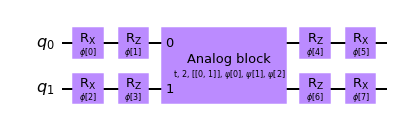

In [8]:
cirq = digital_analog_ansatz(H2_op)
cirq.draw(output="mpl")

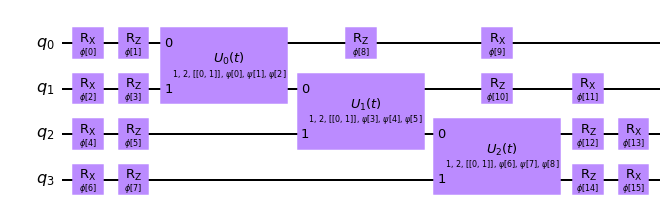

In [9]:
cirq = digital_analog_ansatz(LiH_op, "staggered")
cirq.draw(output="mpl")

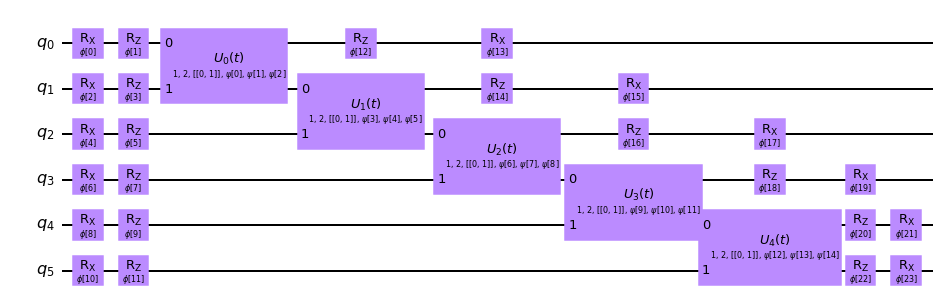

In [10]:
cirq = digital_analog_ansatz(BeH2_op,"staggered")
cirq.draw(output="mpl")

In [36]:
def digital_equivalent_ansatz(Operator, entanglement = "staggered"):
    # First we need to define variational parameters (at least one) phi[...]
    n_qubits = Operator.num_qubits
    phi = ParameterVector("$\phi$", 4 * n_qubits)
    if entanglement == "staggered":
        psi = ParameterVector("$\psi$",3*(n_qubits - 1))
        
    # Create a quantum circuit that is used for the ansatz
    ansatz = QuantumCircuit(n_qubits)
    #circuit
    for i in range(n_qubits):
        ansatz.rx(phi[2*i], i)
        ansatz.rz(phi[2*i+1], i)
    if entanglement == "staggered":
        for i in range(n_qubits - 1):
            #ansatz.digital_eq(connectivity=[[0, 1]], h_coeffs= psi[3*i:3*i+3], qubits=[i,i+1], label='$U_{}$'.format(i))
            # Here is where we place CNOTs bracketing a Rz gate acting on the second qubit. 
            # The target qubit of CNOT gates is the second qubit. 
            ansatz.cx(i,i+1)
            ansatz.rz(psi[3*i],i+1)
            ansatz.cx(i,i+1)
            # Digital equivalent for the analog block involving XX-interactions. 
            # We place Hadamards and CNOTs bracketing a Rz gate acting on the second qubit. 
            # The target qubit of CNOT gates is the second qubit. 
            ansatz.h(i)
            ansatz.h(i+1)
            ansatz.cx(i,i+1)
            ansatz.rz(psi[3*i+1],i+1)
            ansatz.cx(i,i+1)
            ansatz.h(i)
            ansatz.h(i+1)
            # Digital equivalent for the analog block involving YY-interactions. 
            # We place Rx(pi/2), Rx(-pi/2), and CNOTs bracketing a Rz gate acting on the second qubit. 
            # The target qubit of CNOT gates is the second qubit. 
            ansatz.rx(np.pi/2,i)
            ansatz.rx(np.pi/2,i+1)
            ansatz.cx(i,i+1)
            ansatz.rz(psi[3*i+2],i+1)
            ansatz.cx(i,i+1)
            ansatz.rx(-np.pi/2,i)
            ansatz.rx(-np.pi/2,i+1)
    ##
    for i in range(n_qubits):
        ansatz.rz(phi[2*n_qubits+2*i], i)
        ansatz.rx(phi[2*n_qubits+2*i+1], i)
    if entanglement == "staggered":
        for i in range(n_qubits -1):
            ansatz.bind_parameters({psi[i]: 0.3})
    return ansatz    

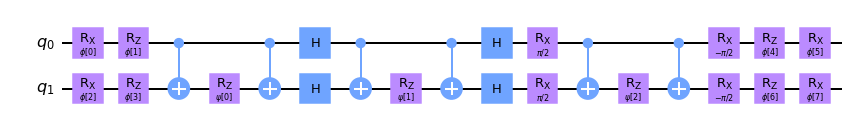

In [12]:
cirq = digital_equivalent_ansatz(H2_op)
cirq.draw(output="mpl")
#cirq.draw(output="mpl",filename="D-H2.png")

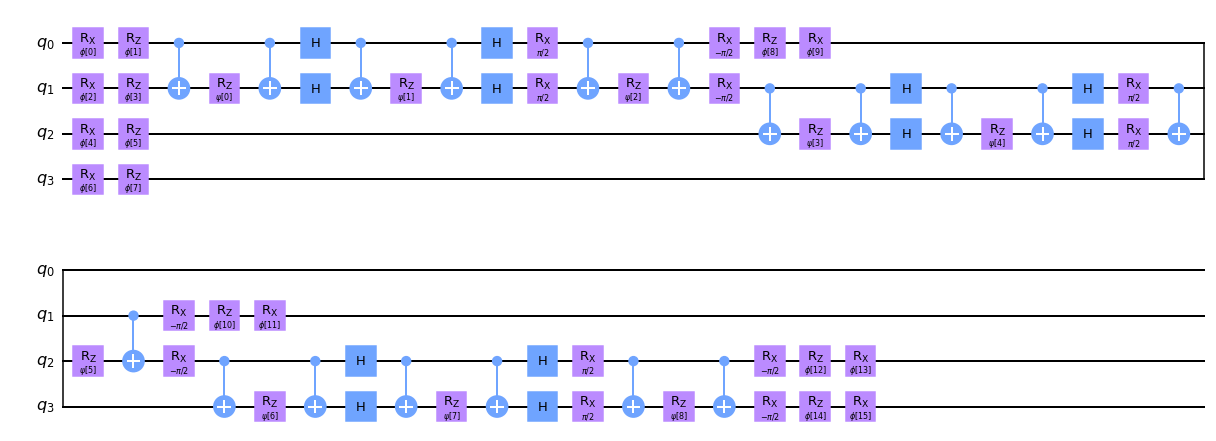

In [13]:
cirq = digital_equivalent_ansatz(LiH_op, "staggered")
cirq.draw(output="mpl")

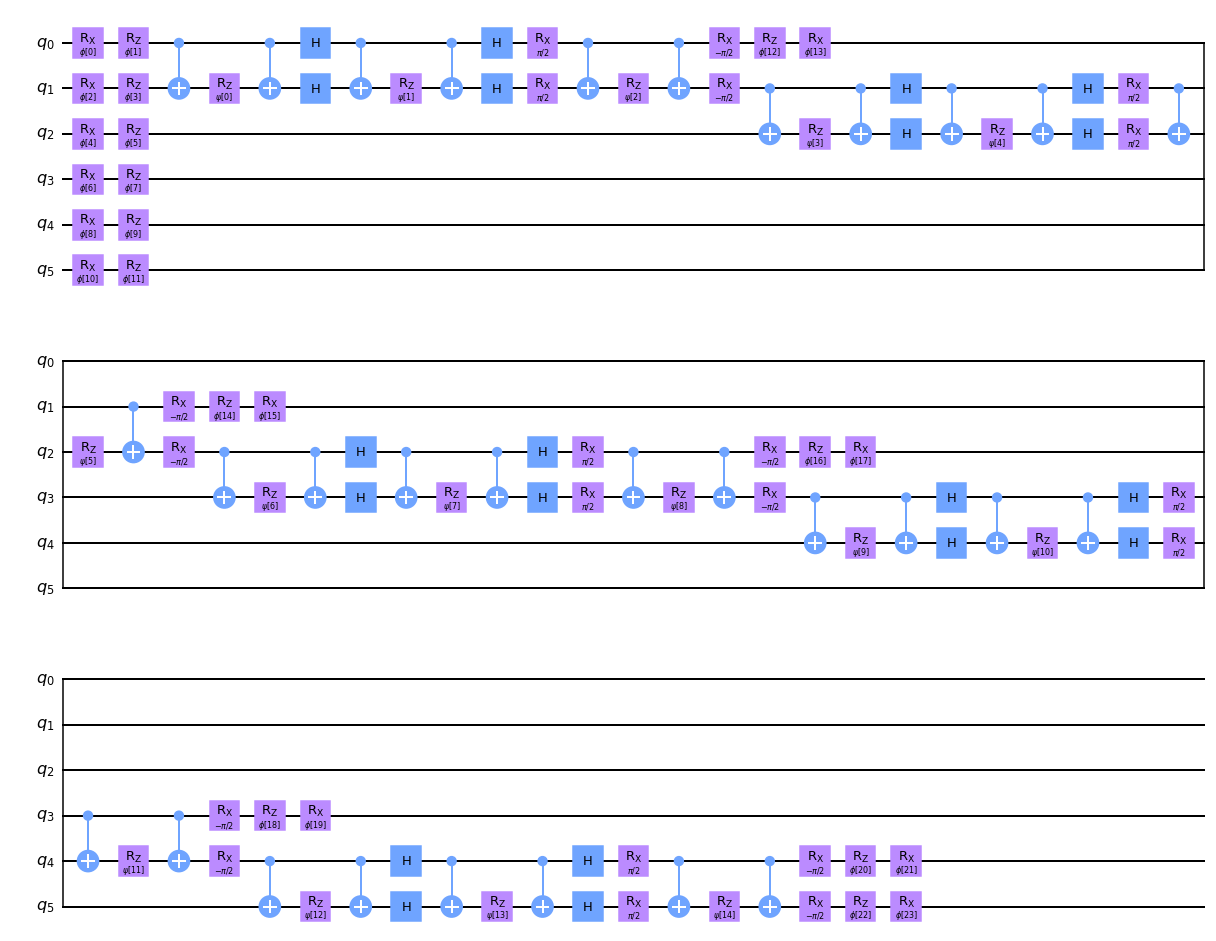

In [14]:
cirq = digital_equivalent_ansatz(BeH2_op,"staggered")
cirq.draw(output="mpl")
#cirq.draw(output="mpl",filename="path/to/my/pict.png")

## Finding GS energy without noise

In [16]:
def find_E0(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations),entanglement="entire"):
    cirq = digital_analog_ansatz(Operator, entanglement)
    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP
    #hist-data
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi, include_custom=True)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    return result, hist

from qiskit.circuit.library import EfficientSU2
def find_E0_digital(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations), entanglement="staggered"):
    if entanglement == "linear":
        n_qubits = Operator.num_qubits
        cirq = EfficientSU2(num_qubits=n_qubits, entanglement=entanglement)
    # Use the digital equivalent of the digital_analog circuit for staggered configuration
    if entanglement == "staggered":
        cirq = digital_equivalent_ansatz(Operator,entanglement="staggered")
    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP
    #hist-data
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi, include_custom=True)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    return result, hist

First find the g.s. energy of 2 qubit model. Here we simply compare the analog block with the digital block. We expect similar results. 

In [19]:
result1_h2, hist1_h2 = find_E0(H2_op,np.random.uniform(low=0.5, high=2.0, size=(11,)), SLSQP(maxiter=1000),"staggered")


In [20]:
result_digit2_h2, hist_digit2_h2 = find_E0_digital(H2_op, np.random.uniform(low=0.5, high=2.0, size=(11,)),SLSQP(maxiter=1000),"staggered")


In [22]:
result_digit1_h2, hist_digit1_h2 = find_E0_digital(H2_op, np.random.uniform(low=0.5, high=2.0, size=(16,)),SLSQP(maxiter=1000),entanglement="linear")

In [31]:
print(result1_h2)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 158,
    'eigenstate': {'01': 0.9941155920096414, '10': 0.10832446502669726},
    'eigenvalue': (-1.8572749831255189+0j),
    'optimal_parameters': {   ParameterVectorElement($\phi$[0]): 1.3364550947366605,
                              ParameterVectorElement($\phi$[5]): 0.1438312642380883,
                              ParameterVectorElement($\phi$[3]): 1.7419349290733823,
                              ParameterVectorElement($\phi$[6]): 1.74058787617376,
                              ParameterVectorElement($\phi$[4]): 0.08115234775000828,
                              ParameterVectorElement($\phi$[1]): 0.8950631250366048,
                              ParameterVectorElement($\phi$[7]): 1.83971049925527,
                              ParameterVectorElement($\psi$[0]): 1.206308638747204,
                              ParameterVectorElement($\psi$[1]): 2.2892868335687346,
                              ParameterVectorElement

In [33]:
print(result_digit2_h2)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 146,
    'eigenstate': {'01': 0.9941777145275592, '10': 0.10775282797569118},
    'eigenvalue': (-1.8572749987729+0j),
    'optimal_parameters': {   ParameterVectorElement($\psi$[2]): 1.401963527695267,
                              ParameterVectorElement($\phi$[0]): 0.6756597277778371,
                              ParameterVectorElement($\phi$[1]): 1.695161062410527,
                              ParameterVectorElement($\phi$[7]): 0.8805575056254792,
                              ParameterVectorElement($\phi$[5]): 1.830696395516232,
                              ParameterVectorElement($\phi$[4]): -0.27426783430456625,
                              ParameterVectorElement($\phi$[6]): 1.3731650671361846,
                              ParameterVectorElement($\psi$[0]): 1.6065535606393955,
                              ParameterVectorElement($\psi$[1]): 1.2197898036175774,
                              ParameterVectorElement

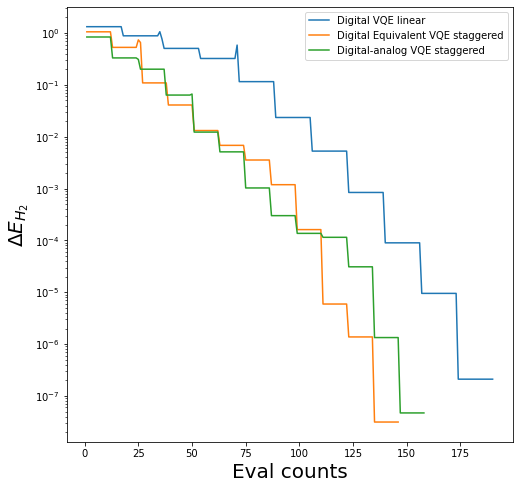

In [25]:
ref_value_h2 = energy_solver(H2_op)
values1_h2, counts1_h2 = hist1_h2
#values2, counts2 = hist2_h2
values_digit1_h2, counts_digit1_h2 = hist_digit1_h2
values_digit2_h2, counts_digit2_h2 = hist_digit2_h2
plt.figure(figsize=(8,8))
plt.plot(counts_digit1_h2, values_digit1_h2-ref_value_h2,label="Digital VQE linear")
plt.plot(counts_digit2_h2, values_digit2_h2-ref_value_h2,label="Digital Equivalent VQE staggered")
plt.plot(counts1_h2, values1_h2-ref_value_h2,label="Digital-analog VQE staggered")
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.legend()

We can see that for 2 qubit circuits the DA-VQE and the digital equivalent circuit based implementation of VQE are virtually identical. Analog blocks do not really give any advantage in the case without noise. 

In [35]:
result1, hist1 = find_E0(LiH_op,np.random.uniform(low=0.5, high=2.0, size=(25,)), SLSQP(maxiter=1500),"staggered")


In [37]:
result2, hist2 = find_E0(LiH_op,np.random.uniform(low=0.5, high=2.0, size=(20,)), SLSQP(maxiter=1500),"entire")

In [38]:
result_digit1, hist_digit1 = find_E0_digital(LiH_op, np.random.uniform(low=0.5, high=2.0, size=(32,)),SLSQP(maxiter=1500),entanglement="linear")

In [39]:
result_digit2, hist_digit2 = find_E0_digital(LiH_op, np.random.uniform(low=0.5, high=2.0, size=(25,)),SLSQP(maxiter=1500))

In [36]:
print(result1)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 633,
    'eigenstate': {   '0101': 0.99975293390605,
                      '0111': 0.011113855611859676,
                      '1111': 0.019249762587725452},
    'eigenvalue': (-8.890893050603081+0j),
    'optimal_parameters': {   ParameterVectorElement($\psi$[3]): 1.2621189145103597,
                              ParameterVectorElement($\psi$[8]): 2.385117017627006,
                              ParameterVectorElement($\psi$[4]): 1.7493568765448797,
                              ParameterVectorElement($\psi$[7]): 2.0991854346352055,
                              ParameterVectorElement($\psi$[6]): 0.7257898264790764,
                              ParameterVectorElement($\psi$[2]): 0.18388866686635866,
                              ParameterVectorElement($\phi$[14]): 1.0322773783304051,
                              ParameterVectorElement($\phi$[11]): 0.9791194869595109,
                              ParameterVectorElement

In [40]:
print(result_digit2)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 782,
    'eigenstate': {   '0101': 0.9996911578418576,
                      '1101': 0.01361163766201177,
                      '1111': 0.02079211997282689},
    'eigenvalue': (-8.890907452955659+0j),
    'optimal_parameters': {   ParameterVectorElement($\psi$[8]): 1.5399693137525658,
                              ParameterVectorElement($\phi$[7]): 2.583252733659775,
                              ParameterVectorElement($\phi$[8]): 1.539313280422845,
                              ParameterVectorElement($\psi$[4]): 0.8293549271584093,
                              ParameterVectorElement($\psi$[1]): 2.318561079808175,
                              ParameterVectorElement($\psi$[7]): 1.6026169192514046,
                              ParameterVectorElement($\psi$[2]): 0.40594108351251135,
                              ParameterVectorElement($\psi$[6]): 4.595491658855085,
                              ParameterVectorElement($\ps

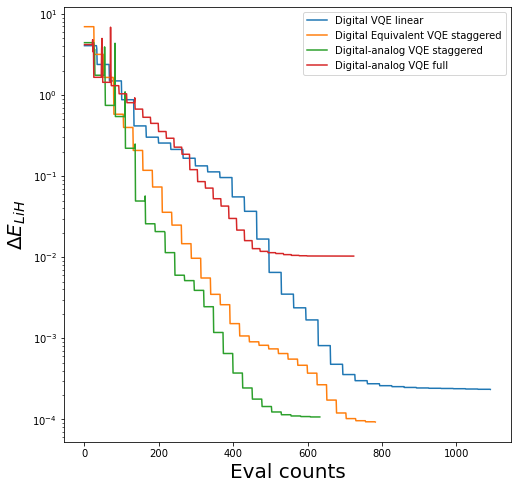

In [42]:
ref_value = energy_solver(LiH_op)
values1, counts1 = hist1
values2, counts2 = hist2
values_digit1, counts_digit1 = hist_digit1
values_digit2, counts_digit2 = hist_digit2
plt.figure(figsize=(8,8))
plt.plot(counts_digit1, values_digit1-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2, values_digit2-ref_value,label="Digital Equivalent VQE staggered")
plt.plot(counts1, values1-ref_value,label="Digital-analog VQE staggered")
plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{LiH}$", fontsize=20)
plt.yscale("log")
plt.legend()

We can see that the DA-VQE (with staggered analog blocks) **converges faster** than even its digital equivalent circuit-based VQE implementation! This shows the advantage of using analog blocks in a staggered configuration. 

## Performance *with* noise

Now we will add a noise model for Aer backend from an actual device. 

First we need to get an actual device backend and from its `configuration` and `properties` we can setup a coupling map and a noise model to match the device. While we could leave the simulator with the default all to all map, this shows how to set the coupling map too. Note: We can also use this coupling map as the entanglement map for the variational form if we choose.

Note: simulation with noise will take longer than without noise.

Terra Mock Backends:

We use real noise data for an IBM Quantum device (ibmq_vigo) using the data stored in Qiskit Terra. 

In [37]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo
device_backend = FakeVigo()
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

seed = 175
iterations = 125

# Define the g.s. eigenvalue finding function with input parameters: time, and ZZ-XX-YY coupling strengths
def find_E0_noise(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations),entanglement="entire", SHOTS=16192):
    
    cirq = digital_analog_ansatz(Operator, entanglement)
    shots = SHOTS
    backend = Aer.get_backend('aer_simulator')
    counts = []
    values = []
    sigma = []
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=SHOTS)

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        sigma.append(std)

    #var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    
    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP with include_custom flag    
    #vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi,include_custom=True)
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    stdevs = sigma
    return result , hist, stdevs
#############################################################################################################
#
#
from qiskit.circuit.library import EfficientSU2
def find_E0_digital_noise(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations), entanglement="staggered",SHOTS=16192):
    if entanglement == "linear":
        n_qubits = Operator.num_qubits
        cirq = EfficientSU2(num_qubits=n_qubits, entanglement=entanglement)
    # Use the digital equivalent of the digital_analog circuit for staggered configuration
    if entanglement == "staggered":
        cirq = digital_equivalent_ansatz(Operator,entanglement="staggered")
    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP
    #hist-data
    shots = SHOTS
    backend = Aer.get_backend('aer_simulator')
    counts = []
    values = []
    sigma = []
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=SHOTS)
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        sigma.append(std)
        
    #OPTIMIZER = SLSQP(maxiter=1000)
    #vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi, include_custom=True)
    #OPTIMIZER = SPSA(maxiter=1000)
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    stdevs = sigma
    return result, hist, stdevs



**Comments:** When we do not use the include_custom=True flag in VQE, then the regular PauliExpectation is returned. This results in higher cost_function_evals and poorer convergence. See result below. We first calculate using the SLSQP optimizer, first without and then with the include_custom=True flag in VQE. A shot-based estimation will be performed later (see below). 

First find the g.s. energy of 2 qubit model. Here we simply compare the analog block with the digital block. We expect different results in the presence of noise because of differing circuit depths. Note that you can **change the number of shots** and generate the plots for that number below. 

In [53]:

result_digit2_h2_n, hist_digit2_h2_n, stdevs_digit2_h2_n = find_E0_digital_noise(H2_op, np.random.uniform(low=0.5, high=2.0, size=(11,)),SLSQP(maxiter=1000),entanglement="staggered",SHOTS=10000)
result_digit1_h2_n, hist_digit1_h2_n, stdevs_digit1_h2_n = find_E0_digital_noise(H2_op, np.random.uniform(low=0.5, high=2.0, size=(16,)),SLSQP(maxiter=1000),entanglement="linear",SHOTS=10000)


In [54]:
result1_h2_n, hist1_h2_n, stdevs1_h2_n = find_E0_noise(H2_op,np.random.uniform(low=0.5, high=2.0, size=(11,)), SLSQP(maxiter=1500),"staggered",SHOTS=10000)



Plot **without standard deviation**. This is relevant only when the incude_custom=True flag is set in the VQE function call (see the find_E0_... functions in which the call is made).

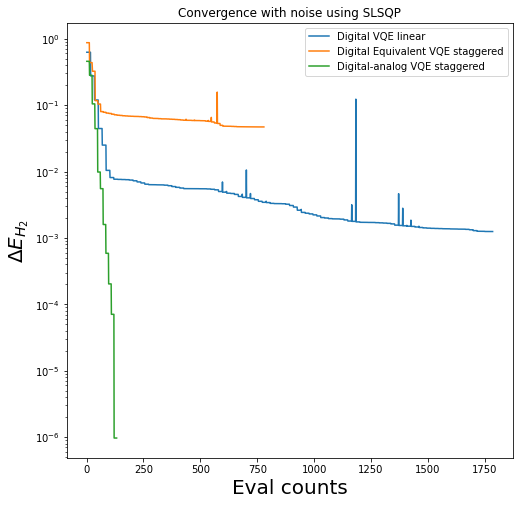

In [23]:
ref_value_h2 = energy_solver(H2_op)
values1_h2_n, counts1_h2_n = hist1_h2_n
#values2, counts2 = hist2_h2
values_digit1_h2_n, counts_digit1_h2_n = hist_digit1_h2_n
values_digit2_h2_n, counts_digit2_h2_n = hist_digit2_h2_n
plt.figure(figsize=(8,8))
plt.plot(counts_digit1_h2_n, values_digit1_h2_n-ref_value_h2,label="Digital VQE linear")
plt.plot(counts_digit2_h2_n, values_digit2_h2_n-ref_value_h2,label="Digital Equivalent VQE staggered")
plt.plot(counts1_h2_n, values1_h2_n-ref_value_h2,label="Digital-analog VQE staggered")
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise using SLSQP')
plt.legend()

Plot the $H_2$ g.s. eigenvalues for D-VQE and DA-VQE **with standard deviation** and for different shots. 

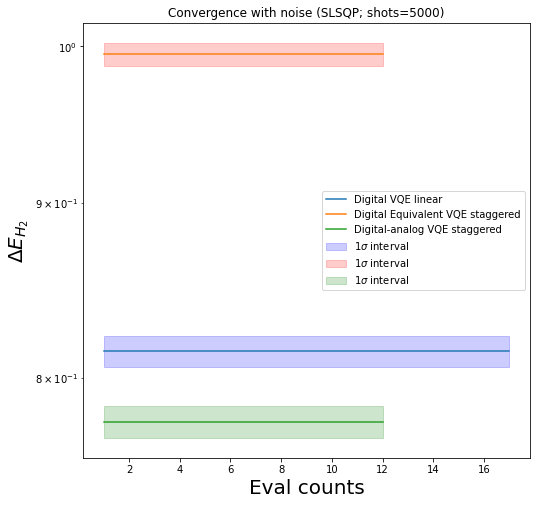

In [52]:
ref_value_h2 = energy_solver(H2_op)
values1_h2_n, counts1_h2_n = hist1_h2_n
#values2, counts2 = hist2_h2
values_digit1_h2_n, counts_digit1_h2_n = hist_digit1_h2_n
values_digit2_h2_n, counts_digit2_h2_n = hist_digit2_h2_n
plt.figure(figsize=(8,8))
plt.plot(counts_digit1_h2_n, values_digit1_h2_n-ref_value_h2,label="Digital VQE linear")
plt.fill_between(counts_digit1_h2_n, values_digit1_h2_n-ref_value_h2 - stdevs_digit1_h2_n, values_digit1_h2_n-ref_value_h2 + stdevs_digit1_h2_n,
                 label="$1\sigma$ interval", color='b',alpha=0.2)
plt.plot(counts_digit2_h2_n, values_digit2_h2_n-ref_value_h2,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_h2_n, values_digit2_h2_n-ref_value_h2 - stdevs_digit2_h2_n, values_digit2_h2_n-ref_value_h2 + stdevs_digit2_h2_n,
                 label="$1\sigma$ interval", color='r',alpha=0.2)
plt.plot(counts1_h2_n, values1_h2_n-ref_value_h2,label="Digital-analog VQE staggered")
plt.fill_between(counts1_h2_n, values1_h2_n-ref_value_h2 - stdevs1_h2_n, values1_h2_n-ref_value_h2 + stdevs1_h2_n,
                 label="$1\sigma$ interval", color='g',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise (SLSQP; shots=5000)')
plt.legend()

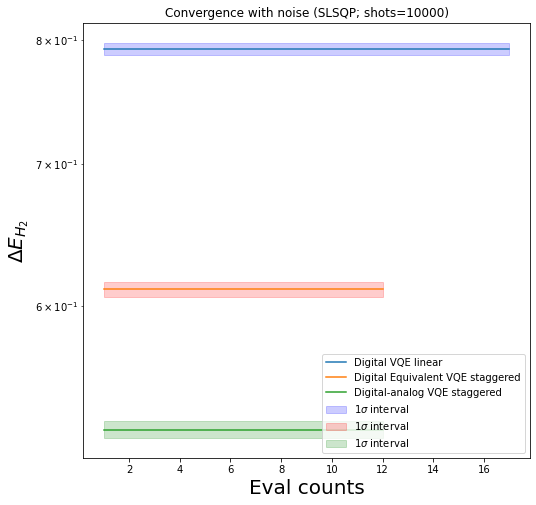

In [55]:
ref_value_h2 = energy_solver(H2_op)
values1_h2_n, counts1_h2_n = hist1_h2_n
#values2, counts2 = hist2_h2
values_digit1_h2_n, counts_digit1_h2_n = hist_digit1_h2_n
values_digit2_h2_n, counts_digit2_h2_n = hist_digit2_h2_n
plt.figure(figsize=(8,8))
plt.plot(counts_digit1_h2_n, values_digit1_h2_n-ref_value_h2,label="Digital VQE linear")
plt.fill_between(counts_digit1_h2_n, values_digit1_h2_n-ref_value_h2 - stdevs_digit1_h2_n, values_digit1_h2_n-ref_value_h2 + stdevs_digit1_h2_n,
                 label="$1\sigma$ interval", color='b',alpha=0.2)
plt.plot(counts_digit2_h2_n, values_digit2_h2_n-ref_value_h2,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_h2_n, values_digit2_h2_n-ref_value_h2 - stdevs_digit2_h2_n, values_digit2_h2_n-ref_value_h2 + stdevs_digit2_h2_n,
                 label="$1\sigma$ interval", color='r',alpha=0.2)
plt.plot(counts1_h2_n, values1_h2_n-ref_value_h2,label="Digital-analog VQE staggered")
plt.fill_between(counts1_h2_n, values1_h2_n-ref_value_h2 - stdevs1_h2_n, values1_h2_n-ref_value_h2 + stdevs1_h2_n,
                 label="$1\sigma$ interval", color='g',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise (SLSQP; shots=10000)')
plt.legend()

In [56]:
result1_n, hist1_n, stdevs1_n = find_E0_noise(LiH_op,np.random.uniform(low=0.5, high=2.0, size=(25,)), SLSQP(maxiter=1500),entanglement="staggered", SHOTS=500)



In [26]:
result_digit2_n, hist_digit2_n, stdevs_digit2_n = find_E0_digital_noise(LiH_op, np.random.uniform(low=0.5, high=2.0, size=(25,)),SLSQP(maxiter=1500),entanglement="staggered", SHOTS=500)



Plots using SLSQP optimizer with the include_custom=True flag. 

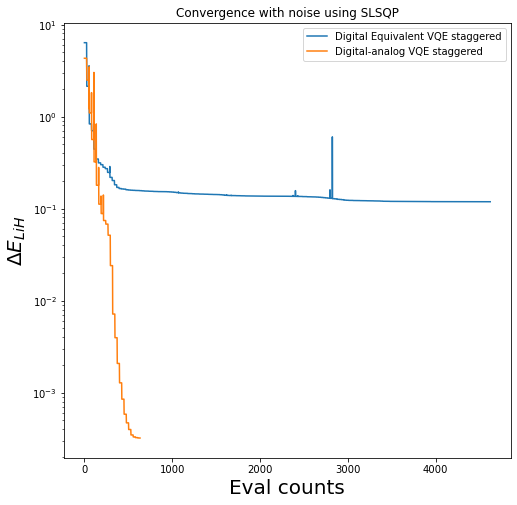

In [27]:
ref_value = energy_solver(LiH_op)
values1_n, counts1_n = hist1_n
#values2, counts2 = hist2
#values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_n, counts_digit2_n = hist_digit2_n
plt.figure(figsize=(8,8))
#plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_n, values_digit2_n-ref_value,label="Digital Equivalent VQE staggered")

plt.plot(counts1_n, values1_n-ref_value,label="Digital-analog VQE staggered")

#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{LiH}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise using SLSQP')
plt.legend()

## Shot-based estimations using SPSA optimizer: 

Using SPSA as the optimizer and controlling the number of shots (max shots set to about 16000).  

In [57]:
result1_n1, hist1_n1, stdevs1_n1 = find_E0_noise(LiH_op,np.random.uniform(low=0.5, high=2.0, size=(25,)), SPSA(maxiter=500),entanglement="staggered",SHOTS=1000)



In [58]:
result_digit2_n1, hist_digit2_n1, stdevs_digit2_n1 = find_E0_digital_noise(LiH_op, np.random.uniform(low=0.5, high=2.0, size=(25,)),SPSA(maxiter=500),entanglement="staggered",SHOTS=1000)



In [70]:
result1_h2_n, hist1_h2_n, stdevs1_h2_n = find_E0_noise(H2_op,np.random.uniform(low=0.5, high=2.0, size=(11,)), SPSA(maxiter=500),entanglement="staggered",SHOTS=5000)



In [72]:
result_digit2_h2_n, hist_digit2_h2_n, stdevs_digit2_h2_n = find_E0_digital_noise(H2_op, np.random.uniform(low=0.5, high=2.0, size=(11,)),SLSQP(maxiter=500),entanglement="staggered",SHOTS=5000)



**Plots for LiH**

 Using SPSA optimizer (shots=16192)

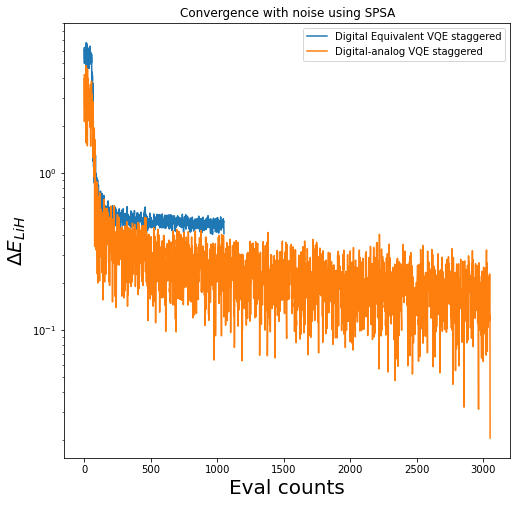

In [26]:
ref_value = energy_solver(LiH_op)
values1_n1, counts1_n1 = hist1_n1
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_n1, counts_digit2_n1 = hist_digit2_n1
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_n1, values_digit2_n1-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_n1, values_digit2_n1-ref_value - stdevs_digit2_n1, values_digit2_n1-ref_value + stdevs_digit2_n1,
                 label="$1\sigma$ interval", color='b',alpha=0.2)
plt.plot(counts1_n1, values1_n1-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_n1, values1_n1-ref_value - stdevs1_n1, values1_n1-ref_value + stdevs1_n1,
                 label="$1\sigma$ interval", color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{LiH}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise using SPSA')
plt.legend()

Using SPSA optimizer, showing standard deviation (shots=1000)

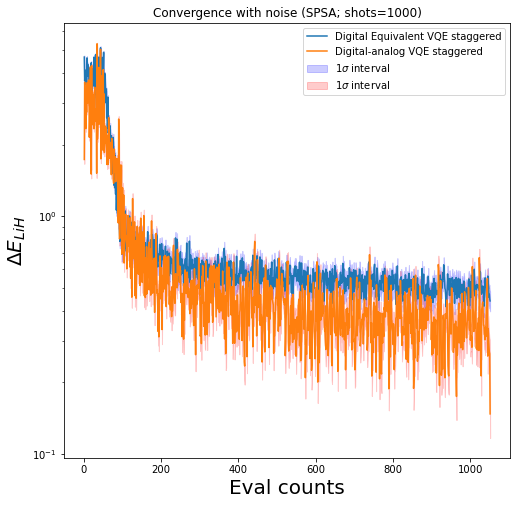

In [66]:
ref_value = energy_solver(LiH_op)
values1_n1, counts1_n1 = hist1_n1
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_n1, counts_digit2_n1 = hist_digit2_n1
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_n1, values_digit2_n1-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_n1, values_digit2_n1-ref_value - stdevs_digit2_n1, values_digit2_n1-ref_value + stdevs_digit2_n1,
                 label="$1\sigma$ interval", color='b',alpha=0.2)
plt.plot(counts1_n1, values1_n1-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_n1, values1_n1-ref_value - stdevs1_n1, values1_n1-ref_value + stdevs1_n1,
                 label="$1\sigma$ interval", color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{LiH}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise (SPSA; shots=1000)')
plt.legend()

**Plots for $H_2$**

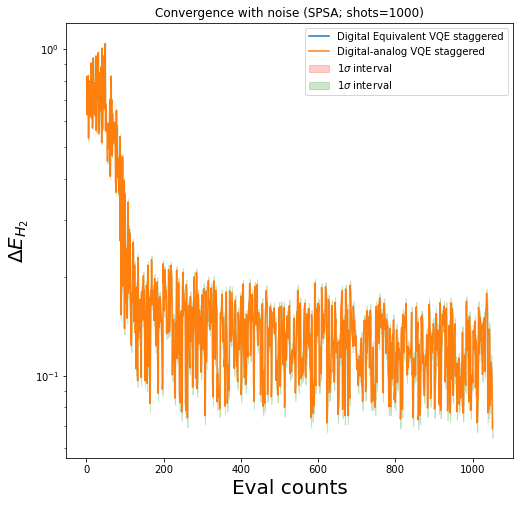

In [73]:
ref_value_h2 = energy_solver(H2_op)
values1_h2_n, counts1_h2_n = hist1_h2_n
#values2, counts2 = hist2_h2
#values_digit1_h2_n, counts_digit1_h2_n = hist_digit1_h2_n
values_digit2_h2_n, counts_digit2_h2_n = hist_digit2_h2_n
plt.figure(figsize=(8,8))
#plt.plot(counts_digit1_h2_n, values_digit1_h2_n-ref_value_h2,label="Digital VQE linear")
#plt.fill_between(counts_digit1_h2_n, values_digit1_h2_n-ref_value_h2 - stdevs_digit1_h2_n, values_digit1_h2_n-ref_value_h2 + stdevs_digit1_h2_n,label="$1\sigma$ interval", color='b',alpha=0.2)
plt.plot(counts_digit2_h2_n, values_digit2_h2_n-ref_value_h2,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_h2_n, values_digit2_h2_n-ref_value_h2 - stdevs_digit2_h2_n, values_digit2_h2_n-ref_value_h2 + stdevs_digit2_h2_n,label="$1\sigma$ interval",color='r',alpha=0.2)
plt.plot(counts1_h2_n, values1_h2_n-ref_value_h2,label="Digital-analog VQE staggered")
plt.fill_between(counts1_h2_n, values1_h2_n-ref_value_h2 - stdevs1_h2_n, values1_h2_n-ref_value_h2 + stdevs1_h2_n,label="$1\sigma$ interval",color='g',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise (SPSA; shots=1000)')
plt.legend()

## Performance *with* noise and measurement error mitigation

Now we will add method for measurement error mitigation, which increases the fidelity of measurement. Here we choose `CompleteMeasFitter` to mitigate the measurement error. The calibration matrix will auto-refresh every 30 minute (default value).


In [76]:
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

from qiskit.utils.mitigation import CompleteMeasFitter

def find_E0_noise_mitigation(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations),entanglement="entire",SHOTS=16192):
    
    cirq = digital_analog_ansatz(Operator, entanglement)
    shots = SHOTS
    backend = Aer.get_backend('aer_simulator')
    counts = []
    values = []
    sigma = []
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=SHOTS, 
                         measurement_error_mitigation_cls=CompleteMeasFitter, 
                         cals_matrix_refresh_period=30)

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        sigma.append(std)

    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP    
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    stdevs = sigma
    return result , hist, stdevs   
###################################
#

from qiskit.circuit.library import EfficientSU2
def find_E0_digital_noise_mitigation(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations), entanglement="staggered",SHOTS=16192):
    if entanglement == "linear":
        n_qubits = Operator.num_qubits
        cirq = EfficientSU2(num_qubits=n_qubits, entanglement=entanglement)
    # Use the digital equivalent of the digital_analog circuit for staggered configuration
    if entanglement == "staggered":
        cirq = digital_equivalent_ansatz(Operator,entanglement="staggered")
    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP
    #hist-data
    shots = SHOTS
    backend = Aer.get_backend('aer_simulator')
    counts = []
    values = []
    sigma = []
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=SHOTS, 
                         measurement_error_mitigation_cls=CompleteMeasFitter, 
                         cals_matrix_refresh_period=30)
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        sigma.append(std)
        
    #OPTIMIZER = SLSQP(maxiter=1000)
    #vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi, include_custom=True)
    #OPTIMIZER = SPSA(maxiter=1000)
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    stdevs = sigma
    return result, hist, stdevs 




In [102]:
result1_nm, hist1_nm, stdevs_nm = find_E0_noise_mitigation(H2_op,np.random.uniform(low=0.5, high=2.0, size=(11,)), SPSA(maxiter=500),entanglement="staggered", SHOTS=40000)




In [103]:
result_digit2_n, hist_digit2_nm, stdevs_digit2_nm = find_E0_digital_noise(H2_op, np.random.uniform(low=0.5, high=2.0, size=(11,)),SPSA(maxiter=500), entanglement="staggered", SHOTS=40000)



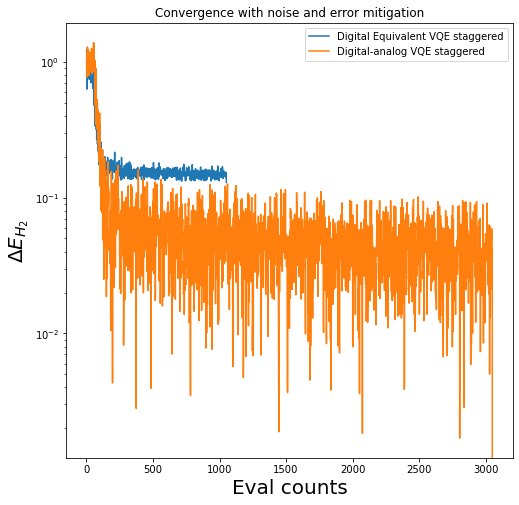

In [28]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise and error mitigation')
plt.legend()

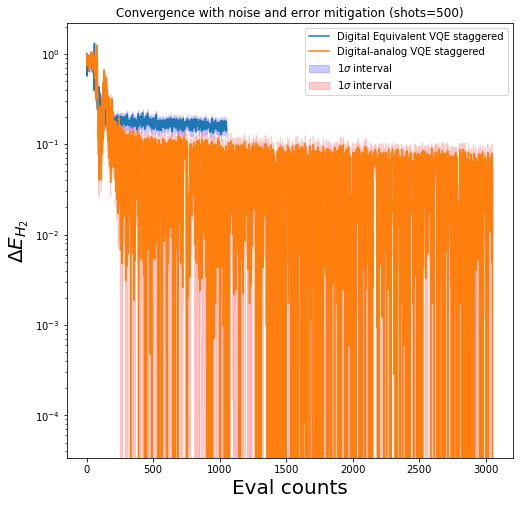

In [82]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_nm, values_digit2_nm-ref_value - stdevs_digit2_nm, values_digit2_nm-ref_value + stdevs_digit2_nm,label="$1\sigma$ interval",color='b',alpha=0.2)
#
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_nm, values1_nm-ref_value - stdevs_nm, values1_nm-ref_value + stdevs_nm,label="$1\sigma$ interval",color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise and error mitigation (shots=500)')
plt.legend()

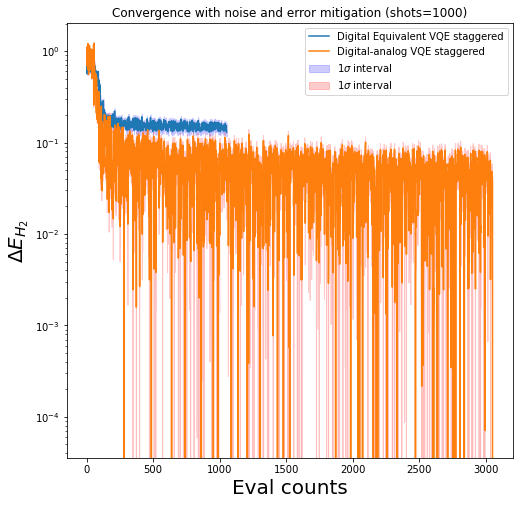

In [85]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_nm, values_digit2_nm-ref_value - stdevs_digit2_nm, values_digit2_nm-ref_value + stdevs_digit2_nm,label="$1\sigma$ interval",color='b',alpha=0.2)
#
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_nm, values1_nm-ref_value - stdevs_nm, values1_nm-ref_value + stdevs_nm,label="$1\sigma$ interval",color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise and error mitigation (shots=1000)')
plt.legend()

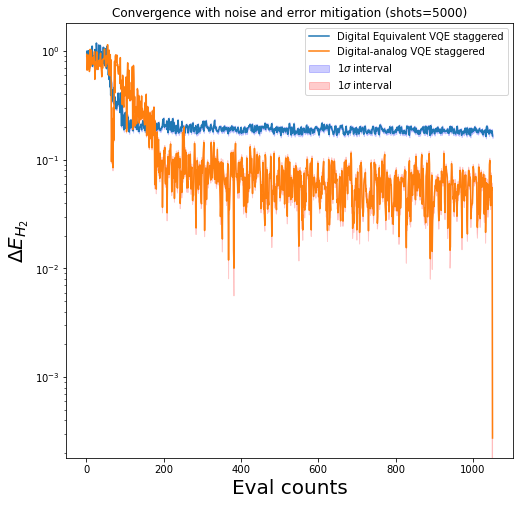

In [88]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_nm, values_digit2_nm-ref_value - stdevs_digit2_nm, values_digit2_nm-ref_value + stdevs_digit2_nm,label="$1\sigma$ interval",color='b',alpha=0.2)
#
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_nm, values1_nm-ref_value - stdevs_nm, values1_nm-ref_value + stdevs_nm,label="$1\sigma$ interval",color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise and error mitigation (shots=5000)')
plt.legend()

**Comments:** Even for a 2-qubit QC (for g.s. of H2) the DA is better than its digital equivalent with noise mitigation! One note of caution is that this is a simulation, so the noise is dependent only on the number of gates and not on their details. However, given the better estimate for energy that DA-VQE offers with noise, the choice is clear! 

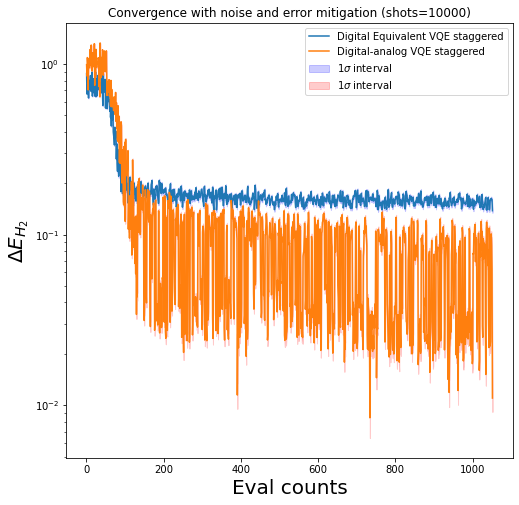

In [91]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_nm, values_digit2_nm-ref_value - stdevs_digit2_nm, values_digit2_nm-ref_value + stdevs_digit2_nm,label="$1\sigma$ interval",color='b',alpha=0.2)
#
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_nm, values1_nm-ref_value - stdevs_nm, values1_nm-ref_value + stdevs_nm,label="$1\sigma$ interval",color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise and error mitigation (shots=10000)')
plt.legend()

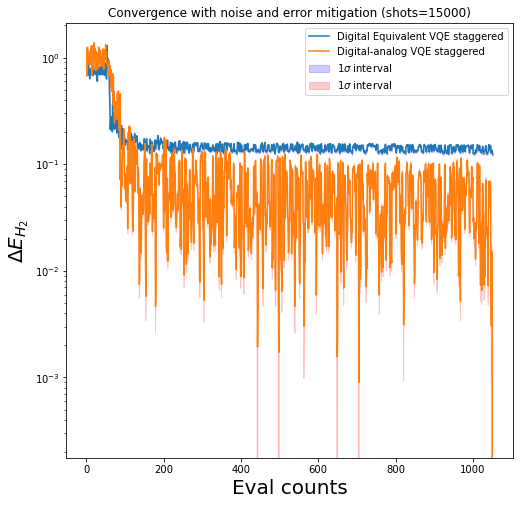

In [95]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_nm, values_digit2_nm-ref_value - stdevs_digit2_nm, values_digit2_nm-ref_value + stdevs_digit2_nm,label="$1\sigma$ interval",color='b',alpha=0.2)
#
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_nm, values1_nm-ref_value - stdevs_nm, values1_nm-ref_value + stdevs_nm,label="$1\sigma$ interval",color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise and error mitigation (shots=15000)')
plt.legend()

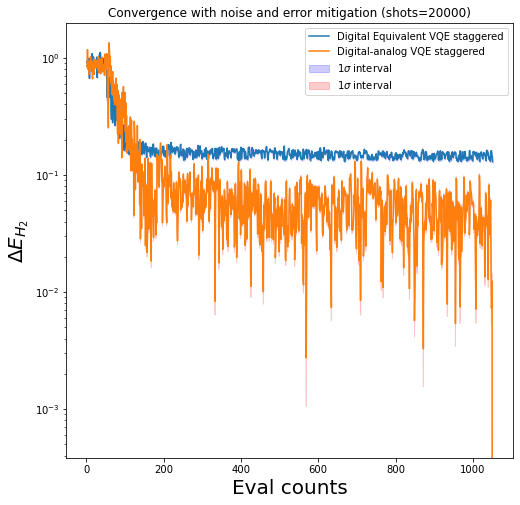

In [98]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_nm, values_digit2_nm-ref_value - stdevs_digit2_nm, values_digit2_nm-ref_value + stdevs_digit2_nm,label="$1\sigma$ interval",color='b',alpha=0.2)
#
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_nm, values1_nm-ref_value - stdevs_nm, values1_nm-ref_value + stdevs_nm,label="$1\sigma$ interval",color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise and error mitigation (shots=20000)')
plt.legend()

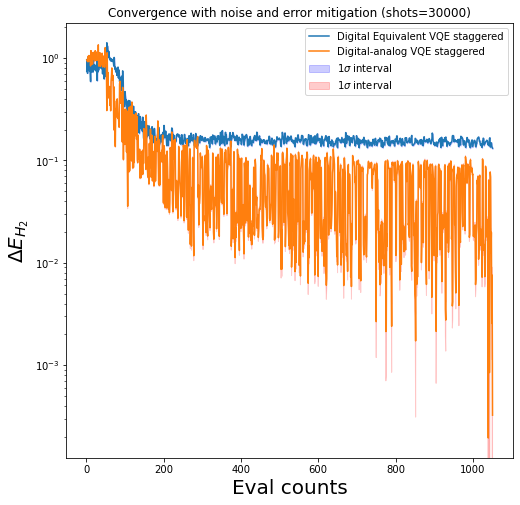

In [101]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_nm, values_digit2_nm-ref_value - stdevs_digit2_nm, values_digit2_nm-ref_value + stdevs_digit2_nm,label="$1\sigma$ interval",color='b',alpha=0.2)
#
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_nm, values1_nm-ref_value - stdevs_nm, values1_nm-ref_value + stdevs_nm,label="$1\sigma$ interval",color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
plt.yscale("log")
plt.title('Convergence with noise and error mitigation (shots=30000)')
plt.legend()

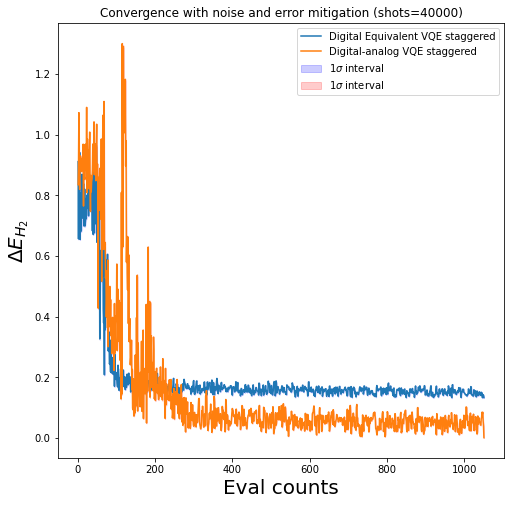

In [108]:
ref_value = energy_solver(H2_op)
values1_nm, counts1_nm = hist1_nm
##values2, counts2 = hist2
##values_digit1_n, counts_digit1_n = hist_digit1_n
values_digit2_nm, counts_digit2_nm = hist_digit2_nm
plt.figure(figsize=(8,8))
##plt.plot(counts_digit1_n, values_digit1_n-ref_value,label="Digital VQE linear")
plt.plot(counts_digit2_nm, values_digit2_nm-ref_value,label="Digital Equivalent VQE staggered")
plt.fill_between(counts_digit2_nm, values_digit2_nm-ref_value - stdevs_digit2_nm, values_digit2_nm-ref_value + stdevs_digit2_nm,label="$1\sigma$ interval",color='b',alpha=0.2)
#
plt.plot(counts1_nm, values1_nm-ref_value,label="Digital-analog VQE staggered")
plt.fill_between(counts1_nm, values1_nm-ref_value - stdevs_nm, values1_nm-ref_value + stdevs_nm,label="$1\sigma$ interval",color='r',alpha=0.2)
#plt.plot(counts2, values2-ref_value,label="Digital-analog VQE full")
plt.xlabel("Eval counts",fontsize=20)
plt.ylabel("$\Delta{E}_{H_2}$", fontsize=20)
#plt.yscale("log")
plt.title('Convergence with noise and error mitigation (shots=40000)')
plt.legend()

### Conclusions

We see that the DA-VQE has out performed D-VQE in the presence of noise even for a simple 2-qubit circuit designed for the $H_2$ ground state eigenvalue. This shows that using the interactions XX-YY-ZZ for 2-qubit is the optimal design for the analog block.  